Saving car data.csv to car data (1).csv
Dataset Loaded Successfully

  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 n

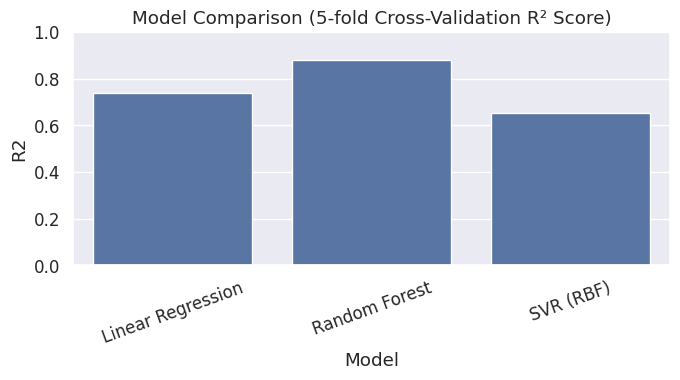


Best Model Detected: Random Forest

Training Best Model...

Evaluation on Test Set:
RMSE: 0.9101444330749789
R² Score: 0.9640398580583994


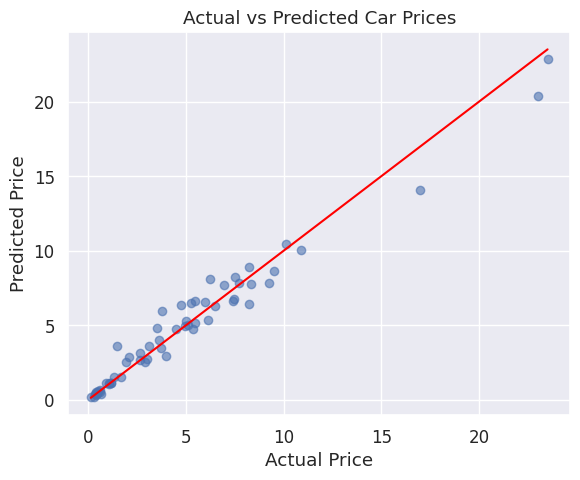


Model saved as car_price_model.joblib


In [3]:
# ============================================================
# TASK 3: CAR PRICE PREDICTION WITH MACHINE LEARNING
# FULL COLAB CODE (UPLOAD DATASET)
# ============================================================

# ------------------ 1. UPLOAD DATASET -----------------------

from google.colab import files
uploaded = files.upload()   # Upload your car price CSV file

import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import joblib

sns.set_style("whitegrid") # Corrected from plt.style.use("seaborn-whitegrid")
sns.set(font_scale=1.1)

# Read the uploaded file
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print("Dataset Loaded Successfully\n")
print(df.head())

# ------------------ 2. DATA CLEANING ------------------------

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isna().sum())

# Drop rows with missing values
df = df.dropna()

# Identify target column (price)
target_col = None
for col in df.columns:
    if "price" in col.lower() or "amount" in col.lower():
        target_col = col
        break

if target_col is None:
    raise ValueError("No price column found. Make sure dataset has a price field.")

print("\nDetected Price Column:", target_col)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# ------------------ 3. ENCODE CATEGORICAL FEATURES ----------

categorical_cols = [col for col in X.columns if X[col].dtype == object]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print("\nCategorical Columns:", categorical_cols)
print("Numeric Columns:", numeric_cols)

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# ------------------ 4. MODEL DEFINITIONS ---------------------

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "SVR (RBF)": SVR(kernel="rbf")
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

print("\nModels Ready:", list(pipelines.keys()))

# ------------------ 5. TRAIN-TEST SPLIT ----------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# ------------------ 6. CROSS-VALIDATION ----------------------

print("\nPerforming Model Comparison...")

cv_results = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")
    cv_results[name] = scores
    print(f"{name}: R² = {scores.mean():.4f} (+/- {scores.std():.4f})")

# Convert results to DataFrame
cv_df = pd.DataFrame({
    "Model": list(cv_results.keys()),
    "R2": [cv_results[m].mean() for m in cv_results]
})

# Barplot of performance
plt.figure(figsize=(7, 4))
sns.barplot(data=cv_df, x="Model", y="R2")
plt.title("Model Comparison (5-fold Cross-Validation R² Score)")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Best model selection
best_model_name = cv_df.sort_values("R2", ascending=False).iloc[0]["Model"]
best_pipeline = pipelines[best_model_name]

print("\nBest Model Detected:", best_model_name)

# ------------------ 7. TRAIN BEST MODEL ----------------------

print("\nTraining Best Model...")
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)

# ------------------ 8. EVALUATION ----------------------------

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation on Test Set:")
print("RMSE:", rmse)
print("R² Score:", r2)

# ------------------ 9. VISUALIZATION -------------------------

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.tight_layout()
plt.show()

# ------------------ 10. SAVE MODEL ---------------------------

joblib.dump(best_pipeline, "car_price_model.joblib")
print("\nModel saved as car_price_model.joblib")